In [1]:
### Instantenous Phase calculation

import numpy as np
import scipy as sp
import mne
import matplotlib
import matplotlib.pyplot as plt
from mne.datasets import spm_face
from scipy import fft, arange, signal
from mne.preprocessing import ICA
from mne.minimum_norm import make_inverse_operator, apply_inverse_epochs, compute_source_psd_epochs, source_band_induced_power, source_induced_power, compute_source_psd
%matplotlib qt
# plt.ion()

raw_path = '/home/robertofelipe_sg/Documents/EEG_Data/P102_BSL_S1_PRE.vhdr'
# raw_path = '/home/robertofelipe_sg/Documents/EEG_Data/P202_1_1_BSL_PRE.vhdr'

# Read input file
raw = mne.io.read_raw_brainvision(raw_path, preload=True)

# Read montage file
montage = mne.channels.read_custom_montage(fname='ActCap_Sion.bvef', coord_frame='head')
print(type(montage))
raw.set_montage(montage)

# Event triggers and conditions
#     events = mne.find_events(raw)
events, E = mne.events_from_annotations(raw, event_id={'Stimulus/S  1': 1, 'Stimulus/S  2': 2, 'Stimulus/S  3': 3})
print(len(events),E)

eventsofint = np.zeros((150, 3), dtype=int)
cor = np.zeros((1,3), dtype=int)
inc = np.zeros((1,3), dtype=int)
j=0
for i, event in enumerate(events):
    if j==150:
        break
    elif event[2,]==1 and events[i-1,2]==3:
        cor[:,0:2] = events[i-1,0:2]
        cor[:,2] = int(31)
        eventsofint[j,:] = cor
        j += 1
    elif event[2,]==2 and events[i-1,2]==3:
        inc[:,0:2] = events[i-1,0:2]
        inc[:,2] = int(32)
        eventsofint[j,:] = inc
        j += 1
a = isinstance(eventsofint, int)
#print(a)
#print(eventsofint)
print(eventsofint.shape)    

# Set EEG average reference
reference = raw.set_eeg_reference(ref_channels='average', projection=False) 

# Filtering
picks = mne.pick_types(raw.info, eeg=True)
raw.filter (l_freq=9.9, h_freq=10.1)
raw.filter (1., None, n_jobs=1, fir_design='firwin')
# raw.plot_psd(tmax=np.inf, fmax=20)
# raw_notch = raw.notch_filter(freqs=50, picks=picks, method='spectrum_fit', filter_length='60s')
# raw.plot_psd(tmax=np.inf, fmax=120)

# Epochs definition
baseline = (-.300, -.100)  # means from the first instant to t = 0
tmin = -1.50
tmax = 1.50
event_id = dict(stim_cor=31, stim_inc=32)
epochs = mne.Epochs(raw, eventsofint, event_id, tmin, tmax, proj=False, picks=picks, detrend=1,
                    baseline=baseline, preload=True) # Based on signals from Trigger
print(epochs)
print(epochs.event_id)

# Resampling
epochs_resampled = epochs.copy().resample(250, npad='auto')
print('New sampling rate:', epochs_resampled.info['sfreq'], 'Hz')
#     epochs_resampled.plot()

# ICA 
ica = ICA(method='fastica', random_state=0) #'picard', n_components=40 WHEN HESSIAN MATRIX DO NOT CONVERGE
ica.fit(epochs_resampled)
ica.plot_sources(epochs_resampled, block=True)
print(ica.exclude)
sub = ica.apply(epochs_resampled)

# Source Reconstruction
data_path = spm_face.data_path()
src = data_path + '/subjects/spm/bem/spm-oct-6-src.fif'
bem = data_path + '/subjects/spm/bem/spm-5120-5120-5120-bem-sol.fif'
cov = mne.compute_covariance(sub, tmin=-.300, tmax=-.100, method='empirical')
fwd = mne.make_forward_solution(sub.info, 'fsaverage', src, bem, eeg=True)
inv = make_inverse_operator(sub.info, fwd, cov, loose=0.2, depth=0.8)
names = ['rh.V1','rh.MT'] # Read labels of interest
labels = [mne.read_label(data_path + '/subjects/spm/label/%s.label' % name) for name in names]

def hilb(sub, inv, labels_parc):
    suh = sub.apply_hilbert()
    stch = apply_inverse_epochs(suh, inv, lambda2=1/9, pick_ori='normal', method='MNE')
    label_tsh = mne.extract_label_time_course(stch, labels_parc, inv['src'], mode='pca_flip', 
                                                     allow_empty=True, return_generator=False)
    datah = np.array(label_tsh, dtype=complex)
    print(datah.shape, datah.dtype)
    datah_avg = np.mean(datah, axis=0) # averaging over epochs
    
    fig1 = plt.figure()
    plt.plot(np.abs(datah_avg[0,:]))
    plt.plot(np.abs(datah_avg[1,:]))
    plt.show()
    
    # Do NOT unwrap phase to be sure it is always between 0 and 2*pi 
    phase_lag = np.degrees(np.angle(datah_avg[1,350:500]) - np.angle(datah_avg[0,350:500]))
    phase_lag = [360+an if an<0 else an for an in phase_lag]
    return phase_lag[25], np.max(phase_lag), np.mean(phase_lag)

def cros(sub, inv, labels_parc):
    # Compute inverse solution on signal
    stc = apply_inverse_epochs(sub, inv, lambda2=1/9, pick_ori='normal', method='MNE')
    label_ts = mne.extract_label_time_course(stc, labels_parc, inv['src'], mode='pca_flip', 
                                                         allow_empty=True,return_generator=False) 
    data = np.array(label_ts)
    print(data.shape, data.dtype)
    data_avg = np.mean(data, axis=0) # averaging over epochs
    
    fig2 = plt.figure()
    plt.plot(np.abs(data_avg[0,:]))
    plt.plot(np.abs(data_avg[1,:]))
    plt.show()
    
    # Find cross-correlation
    xcorr = sp.signal.correlate(data_avg[0,:], data_avg[1,:], mode='same')
    delay_arr = np.linspace(-1.5, 1.5, 750)
    delay = delay_arr[np.argmax(xcorr)]
    lag = 360*10*(delay)%360
    return(delay, lag)

p,l,m = hilb(sub, inv, labels)
p2,l2 = cros(sub, inv, labels)

print(p,l,m)
print(p2,l2)

Extracting parameters from /home/robertofelipe_sg/Documents/EEG_Data/P102_BSL_S1_PRE.vhdr...
Setting channel info structure...
Reading 0 ... 4656199  =      0.000 ...   931.240 secs...


<ipython-input-1-fcb3af41d86c>:20: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(raw_path, preload=True)


KeyboardInterrupt: 

0.025247992870540564 90.89277433394602
0.02603471295060089 93.72496662216321


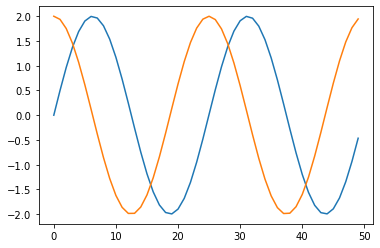

In [10]:
### Dummy signals test 90 Degrees test

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal

t = np.linspace(-1.5,1.5,750)

# Load datasets, taking mean of 100 values in each table row
A = 2*np.sin(2*np.pi*10*t)
B = 2*np.cos(2*np.pi*10*t)
# print(A)
plt.plot(A[0:50])
plt.plot(B[0:50])

phase_lag = np.degrees(np.angle(sp.signal.hilbert(B[350:500])) - np.angle(sp.signal.hilbert(A[350:500])))
phase_lag = [360+an if an<0 else an for an in phase_lag]
print((np.max(phase_lag)*0.1/360), np.max(phase_lag))

xco = sp.signal.correlate(A, B, mode='same')
m = np.argmax(xco)
de = t[m]
l = 360*10*(de)
print(de, l)